## The diagnostic of interferometry

The interferometer measures the line-integrated density along the laser trajectory $l$:
$$
d = \int n_e \mathrm{d} l
$$

Visualization of the channel chords (lines of sight):

In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
from sampler_spline import sampler_spline_main
%matplotlib notebook

<IPython.core.display.Javascript object>


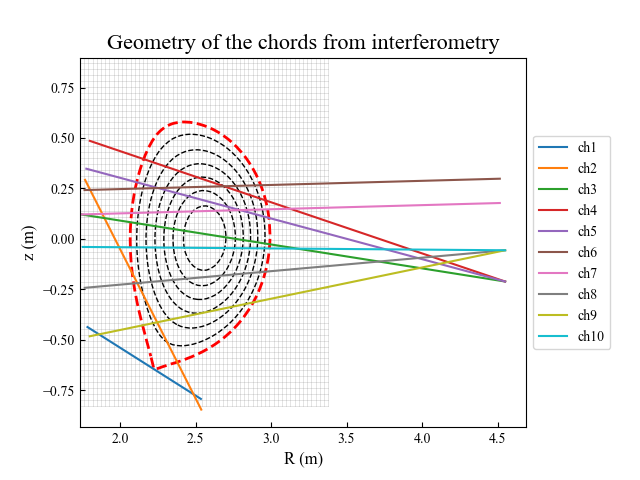

In [2]:
shot = 53259
t = 5.2113

geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}_occ1.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## The forward model

The measured data are simply line-integrated signals, therefore the linear forward model (a mapping from electron density profile $\vec{n}_e$ to line integrals $\vec{d}$) can be constructed using a response matrix (sometimes also referred to as a transfer matrix) $R$:
$$
\vec{d} = R \cdot \vec{n}_e
$$

- $R$: response matrix
- $\vec{d}$: measured line-integrated density of all channels
- $\vec{n}_e$: electron density profile (in flux coordinates $\rho_{tor}$)

## Bayesian inference of electron density profile

### Model the density profile with a cubic spline function

Example density profile calculated by the equilibrium code NICE:

<IPython.core.display.Javascript object>


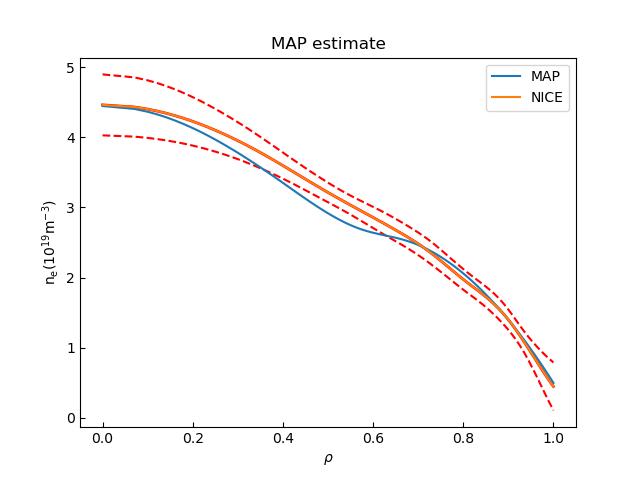

In [4]:
dens_prof.plot_density_profile()

Note:
- The profile is described by a **cubic spline function** $f$, which is determined by **positions of the knots** ($\vec{\xi}$) and **function values at the knots** ($\vec{f}$)
- **Boundary condition** of the spline: the derivative in the center is fixed to be 0, and the derivative at the edge $f_{edge}^{\prime} = f^{\prime}(1)$ is a free parameter (hyperparameter) (refer to https://doi.org/10.1016/j.fusengdes.2015.05.075)

###  Likelihood

Assuming the measurement errors have a gaussian distribution and the variation of all channels are constant. In other words, the measured data $\vec{d} \sim \mathcal{N} (R \cdot \vec{n}_e, \Sigma_d)$, where $\Sigma_d = \sigma_d^2 I$ and $\sigma_d$ is a **hyperparameter**

### Prior

(All priors are given in logarithmic forms for convenience.) 
- Assume the number of knots $E$ is fixed
- Measurement error level $\sigma_d$ (in the likelihood) - Jeffrey's prior:
$$
\log \mathrm{p}(\sigma_d) = \left\{\begin{array}{l}
-\log(\log(\frac{\sigma_{\mathrm{max}}}{\sigma_{\mathrm{min}}})) - \log(\sigma_d); \quad  \sigma_{\mathrm{min}} \leq \sigma_{d} \leq \sigma_{\mathrm{max}}\\
-\mathrm{inf} \quad \text { elsewhere }
\end{array}\right.
$$
- Edge derivative $f_{edge}^{\prime}$ - uniform prior:
$$
\log\mathrm{p}(f_{edge}^{\prime})=\left\{\begin{array}{l}
-\log (f^{\prime}_{\mathrm{max}} - f^{\prime}_{\mathrm{min}}) ; \quad f^{\prime}_{\mathrm{min}} \leq f_{edge}^{\prime} \leq f^{\prime}_{\mathrm{max}} \\
-\mathrm{inf} \quad \text { elsewhere }
\end{array}\right.
$$
- Knot positions $\vec{\xi}$ - uniform prior (sorted first) (see https://doi.org/10.1063/1.2423287)
$$
\log \mathrm{p}(\vec{\xi}|E, \Delta \xi) = \left\{\begin{array}{l} \log\left[(E-2)!\right] - (E-2) \log\left[\xi_{E}-\xi_{1}-(E-1) \Delta \xi\right] ; \quad \xi_i+\Delta\xi \leq \xi_{i+1} \quad \text{for} \quad i=1,2,\ldots,E-1\\
-\mathrm{inf} \quad \text { elsewhere }
\end{array}\right.
$$
- Knot amplitudes $\vec{f}$ - uniform prior
$$
\log\mathrm{p}(\vec{f}|E)=\left\{\begin{array}{l}
-\sum_{j=1}^{E} \log f_{\max} ; \quad 0 \leq f_{j} \leq f_{\max} \quad \text{for} \quad j=1,2,\ldots,E\\
-\mathrm{inf} \quad \text { elsewhere }
\end{array}\right.
$$
- Improved prior distribution for knot amplitudes $\vec{f}$, with smoothness constraint (see https://doi.org/10.1103/PhysRevE.61.1152):
$$
\log\mathrm{p}(\vec{f}, \vec{\xi}|\mu, \alpha, f_{edge}, f_{edge}^{\prime}, \Delta \xi, E)=\left\{\begin{array}{l}
-\sum_{j=1}^{E} \log f_{\max} + \log \mathrm{p}(\vec{\xi}|E, \Delta \xi) - \mu \int_{0}^{1} \vert f^{''}(x) \vert ^2 \mathrm{d}x - \alpha \vert f_{edge} \vert ^2; \quad 0 \leq f_{j} \leq f_{\max } \quad \text{and} \quad \xi_i+\Delta\xi \leq \xi_{i+1} \quad \text{for} \ \text{all} \ i,j\\
-\mathrm{inf} \quad \text { elsewhere }
\end{array}\right.
$$
where the hyperparameters $\mu$ has Jeffrey's priors

### Example of MCMC sampling

Draw samples from the posterior distribution and estimate the mean and standard deviation. The result is compared with the NICE density profile.

In [4]:
#sampler_spline_main()

Estimating MAP ...


KeyboardInterrupt: 

In [5]:
from sampler_spline import Sampler
t = 5.91
shot = 53259
# t = 1.4
# shot = 55191
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}_occ1.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

response = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

sampler = Sampler(interf=interf, equi=equi, response=response, dens_prof=dens_prof)
sampler.MAP()
# sampler.sample(opt='de')
# # sampler.sample(opt='de', file_name='53259_5.21s_mcmc_samples.mat')
# # sampler.load_samples('53259_5.21s_mcmc_samples.mat')
# sampler.plot_posterior(line='mean')

Estimating MAP ...
MAP point found. Cost time: 33.836 s
Negative logpdf: 3.9429058194569566
sigma = 0.10691913906713538
smooth_factor = 0.002000473919157919
first derivative at the edge = -10.13938810988651
Plotting MAP


/home/ubuntu/anaconda3/envs/mthesis/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [10]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.ones(10))
plt.show()